In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
# add the path of the virtual environmentsite-packages to colab system path
sys.path.append("/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages")

In [ ]:
from scvi_colab import install
install()

In [ ]:
import os
import tempfile
import scanpy as sc
import scvi
import seaborn as sns
import torch
from adjustText import adjust_text
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
from glob import iglob
from scipy import sparse
from scipy.sparse import coo_matrix
import math
from scib_metrics.benchmark import Benchmarker

In [ ]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0


Last run with scvi-tools version: 1.2.0


In [ ]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
output_dir = "/content/drive/MyDrive/LeoDai/Private_Data/Integration/scANVI/exc"

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

model_dir = "/content/drive/MyDrive/LeoDai/Private_Data/Integration/scANVI/exc/scvi_model"
integ_dir="/content/drive/MyDrive/LeoDai/Private_Data/Integration/"

In [ ]:
adata_human = sc.read_h5ad(os.path.join(integ_dir,"human_exc_common_genes.h5ad"))
adata_chimp = sc.read_h5ad(os.path.join(integ_dir,"chimp_exc_common_genes.h5ad"))
adata_rat = sc.read_h5ad(os.path.join(integ_dir,"rat_exc_common_genes.h5ad"))
adata_rat
input_dir="/content/drive/MyDrive/LeoDai/Private_Data/Integration/scANVI/rat"
rat_mask = sc.read_h5ad(os.path.join(input_dir,"exc_adata.h5ad"))
rat_mask
adata_rat = adata_rat[rat_mask.obs_names,:]
adata_rat.obs['DE_subclass'] = rat_mask.obs['scvi_subclass']
adata_rat
adata_rat.write_h5ad(os.path.join(integ_dir,"rat_exc_common_genes_scVI_subclass.h5ad"))
full_adata = ad.concat([adata_rat,adata_chimp,adata_human],axis=0, join="inner",merge='same')
full_adata
full_adata.obs.DE_subclass[full_adata.obs["DE_subclass"] == "L2/3 IT"] = "L2_L3_IT"
full_adata.obs.DE_subclass[full_adata.obs["DE_subclass"] == "L5 IT"] = "L5_IT"
full_adata.obs.DE_subclass[full_adata.obs["DE_subclass"] == "L6 CT"] = "L6_CT"
full_adata.obs.DE_subclass[full_adata.obs["DE_subclass"] == "L6 IT"] = "L6_IT"
full_adata.obs.DE_subclass[full_adata.obs["DE_subclass"] == "L5/6 NP"] = "L56_NP"
full_adata.obs.DE_subclass[full_adata.obs["DE_subclass"] == "L5_6NP"] = "L56_NP"
full_adata.obs.DE_subclass[full_adata.obs["DE_subclass"] == "L5 ET"] = "L5_ET"
full_adata.obs.DE_subclass[full_adata.obs["DE_subclass"] == "L6 IT Car3"] = "L6_IT_Car3"
full_adata.obs.DE_subclass[full_adata.obs["DE_subclass"] == "L4_L5_IT"] = "L5_IT"
full_adata.obs.DE_subclass[full_adata.obs["DE_subclass"] == "L5_L6_IT"] = "L5_IT"
full_adata.obs.DE_subclass[full_adata.obs["DE_subclass"] == "L6_b"] = "L6b"
full_adata = full_adata[full_adata.obs["DE_subclass"].isin(full_adata.obs["DE_subclass"].value_counts() != 0).index, :]
full_adata.write_h5ad("/content/drive/MyDrive/LeoDai/Private_Data/Integration/scANVI/exc/exc_full_adata_raw_ratscVI.h5ad",compression="gzip")

In [ ]:
full_adata = sc.read_h5ad("/content/drive/MyDrive/LeoDai/Private_Data/Integration/scANVI/exc/exc_full_adata_raw_ratscVI.h5ad")

In [ ]:
#####
#save raw count =
#normalization
#log transform
full_adata.raw = full_adata

sc.pp.normalize_total(full_adata, target_sum=1e4)
sc.pp.log1p(full_adata)
full_adata.layers["counts"] = full_adata.X.copy()  # preserve counts
  # freeze the state in `.raw`
#highly variable genes top 5000
sc.pp.highly_variable_genes(
    full_adata,
    n_top_genes=1500,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="sample",
)
#Now it’s time to run setup_anndata(), which alerts scvi-tools to the locations of various
#matrices inside the anndata. It’s important to run this function with the correct arguments
#so scvi-tools is notified that your dataset has batches, annotations, etc.
scvi.model.SCVI.setup_anndata(
    full_adata,
    layer="counts",
    categorical_covariate_keys=["sample","species"],
    continuous_covariate_keys=["pct_counts_mt", "pct_counts_ribo"],
)
#create and train the scvi model
#negative binomial
n_latent =30
model = scvi.model.SCVI(full_adata, n_layers=2, n_latent=30, gene_likelihood="nb")
model.train()
model.save(os.path.join(model_dir,"exc_full_adata_scvi_model_v2_" + str(n_latent)), overwrite=True)
#add denoised data back to adata
full_adata.layers["scvi_normalized"] = model.get_normalized_expression(library_size=10e4)
#save scvi output to adata
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
full_adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape
# use scVI latent space for UMAP generation
sc.pp.neighbors(full_adata, use_rep=SCVI_LATENT_KEY)

SCVI_CLUSTERS_KEY = "leiden_scVI"
sc.tl.leiden(full_adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)
sc.tl.umap(full_adata, min_dist=0.5)

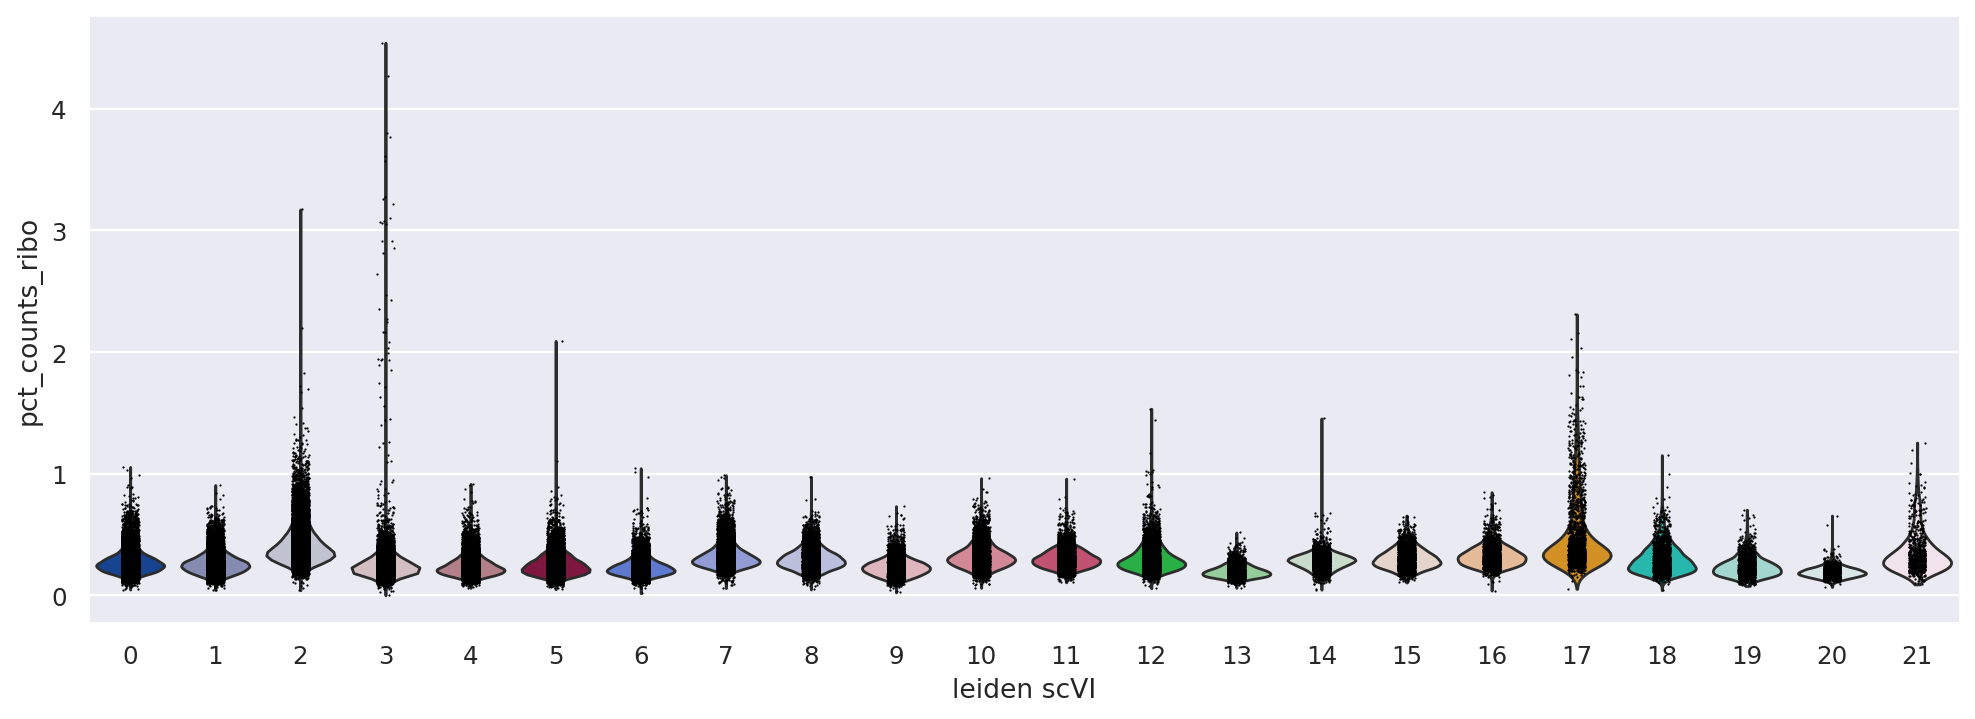

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
sc.pl.violin(full_adata, "pct_counts_ribo", groupby="leiden_scVI", ax=axs)
#sc.pl.violin(full_adata, "leiden", groupby="DE_subclass", ax=axs[1])

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
sc.pl.violin(full_adata, "pct_counts_mt", groupby="leiden_scVI", ax=axs)

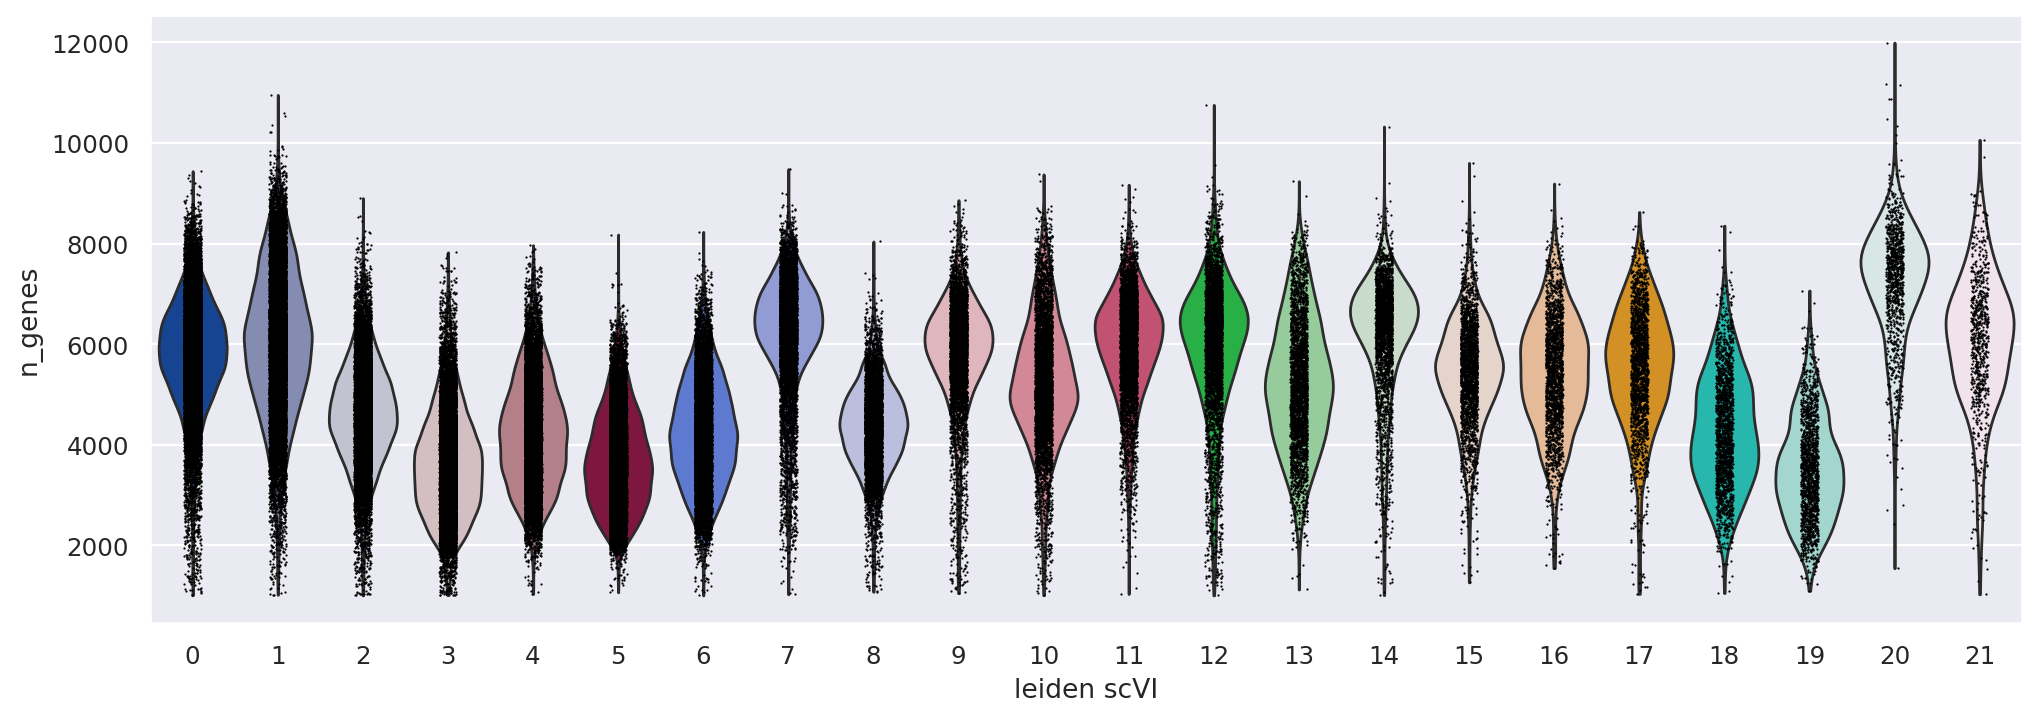

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
sc.pl.violin(full_adata, "n_genes", groupby="leiden_scVI", ax=axs)

<Axes: title={'center': 'species'}, xlabel='UMAP1', ylabel='UMAP2'>

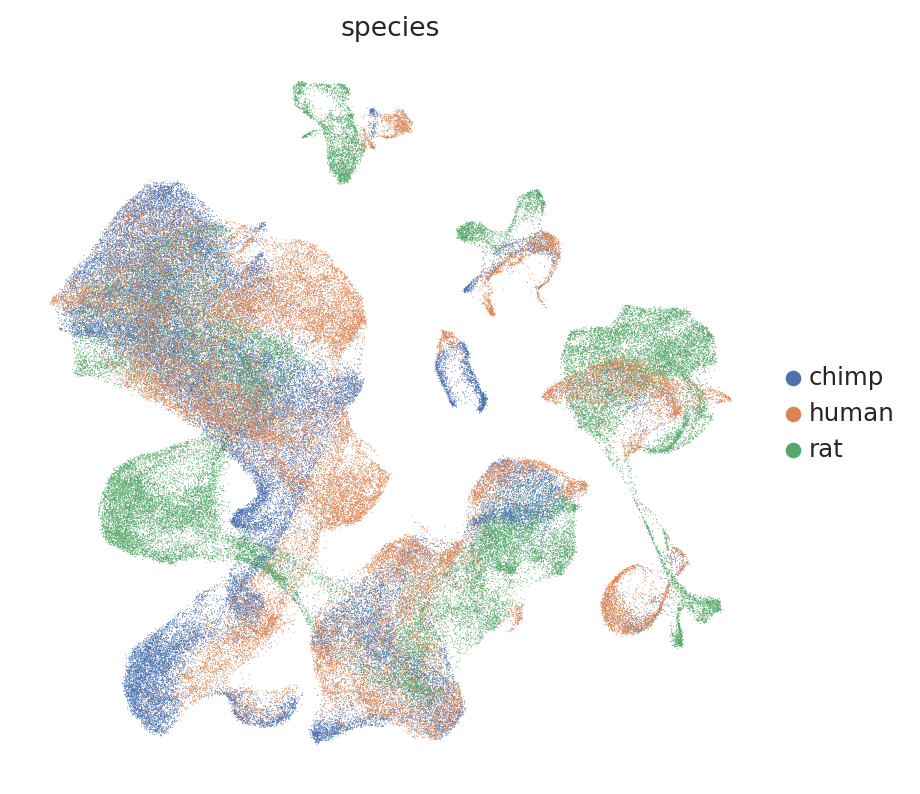

In [ ]:
sc.pl.umap(
    full_adata,
    color=['species'],
    frameon=False,
    cmap="tab20",
    show=False,
    #legend_loc = "on data",
    wspace=0.5
)
#plt.savefig(os.path.join(output_dir,"exc_leiden_number.png"),bbox_inches='tight')

In [ ]:
bm = Benchmarker(
    full_adata,
    batch_key="sample",
    label_key="DE_subclass",
    embedding_obsm_keys=[SCVI_LATENT_KEY],
    n_jobs=4,
)
bm.benchmark()
bm.plot_results_table(min_max_scale=False)

In [ ]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=full_adata,
    labels_key="DE_subclass",
    unlabeled_category="Unknown",
)
scanvi_model.train(max_epochs=20, n_samples_per_label=100)
SCANVI_LATENT_KEY = "X_scANVI"
full_adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(full_adata)
scanvi_model.save(os.path.join(model_dir,"exc_three_species_full_adata_scANvi_model_v2_" + str(n_latent)), overwrite=True)
sc.pp.neighbors(full_adata, use_rep=SCANVI_LATENT_KEY)
SCANVI_CLUSTERS_KEY = "leiden_scANVI"
sc.tl.leiden(full_adata, key_added=SCANVI_CLUSTERS_KEY, resolution=0.5)
sc.tl.umap(full_adata, min_dist=0.4)

In [ ]:
bm = Benchmarker(
    full_adata,
    batch_key="sample",
    label_key="DE_subclass",
    embedding_obsm_keys=[SCANVI_LATENT_KEY, SCVI_LATENT_KEY],
    n_jobs=6,
)
bm.benchmark()
bm.plot_results_table(min_max_scale=False)

In [ ]:
full_adata = sc.read_h5ad("/content/drive/MyDrive/LeoDai/Private_Data/Integration/scANVI/exc/exc_full_adata_raw_ratscVI.h5ad")

In [ ]:
sc.pl.umap(
    full_adata,
    color=["DE_subclass","species",'RORB'],
    frameon=False,
    cmap="tab20",
    legend_loc = "on data",
    legend_fontsize = 'x-small',
    show=False,
    wspace=0.5
)

In [ ]:
#integrate primate data only
primate_adata = full_adata[full_adata.obs['species'].isin(['chimp','human']),:]
primate_adata

In [ ]:
#####
#save raw count =
#normalization
#log transform
primate_adata.raw = primate_adata

sc.pp.normalize_total(primate_adata, target_sum=1e4)
sc.pp.log1p(primate_adata)
primate_adata.layers["counts"] = primate_adata.X.copy()  # preserve counts
  # freeze the state in `.raw`
#highly variable genes top 5000
sc.pp.highly_variable_genes(
    primate_adata,
    n_top_genes=1500,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="sample",
)
#Now it’s time to run setup_anndata(), which alerts scvi-tools to the locations of various
#matrices inside the anndata. It’s important to run this function with the correct arguments
#so scvi-tools is notified that your dataset has batches, annotations, etc.
scvi.model.SCVI.setup_anndata(
    primate_adata,
    layer="counts",
    categorical_covariate_keys=["sample","species"],
    continuous_covariate_keys=["pct_counts_mt", "pct_counts_ribo"],
)
#create and train the scvi model
#negative binomial
n_latent =30
model = scvi.model.SCVI(primate_adata, n_layers=2, n_latent=30, gene_likelihood="nb")
model.train()
model.save(os.path.join(model_dir,"exc_primate_adata_scvi_model_v2_" + str(n_latent)), overwrite=True)

In [ ]:
#add denoised data back to adata
primate_adata.layers["scvi_normalized"] = model.get_normalized_expression(library_size=10e4)
#save scvi output to adata
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
primate_adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape
# use scVI latent space for UMAP generation
sc.pp.neighbors(primate_adata, use_rep=SCVI_LATENT_KEY)

SCVI_CLUSTERS_KEY = "leiden_scVI"
sc.tl.leiden(primate_adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)
sc.tl.umap(primate_adata, min_dist=0.5)

In [ ]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=primate_adata,
    labels_key="DE_subclass",
    unlabeled_category="Unknown",
)
scanvi_model.train(max_epochs=20, n_samples_per_label=100)
SCANVI_LATENT_KEY = "X_scANVI"
primate_adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(primate_adata)
scanvi_model.save(os.path.join(model_dir,"exc_primate_adata_scANvi_model_v2_" + str(n_latent)), overwrite=True)
sc.pp.neighbors(primate_adata, use_rep=SCANVI_LATENT_KEY)
SCANVI_CLUSTERS_KEY = "leiden_scANVI"
sc.tl.leiden(primate_adata, key_added=SCANVI_CLUSTERS_KEY, resolution=0.5)
sc.tl.umap(primate_adata, min_dist=0.4)

In [ ]:
primate_adata.write_h5ad("/content/drive/MyDrive/LeoDai/Private_Data/Integration/scANVI/exc/primate_adata_scANVI_v2.h5ad",compression="gzip")

In [ ]:
SCANVI_LATENT_KEY="X_scANVI"
SCVI_LATENT_KEY="X_scVI"

bm = Benchmarker(
    primate_adata,
    batch_key="sample",
    label_key="DE_subclass",
    embedding_obsm_keys=[SCANVI_LATENT_KEY, SCVI_LATENT_KEY],
    n_jobs=6,
)
bm.benchmark()
bm.plot_results_table(min_max_scale=False)

In [ ]:
SCANVI_LATENT_KEY="X_scANVI"
SCVI_LATENT_KEY="X_scVI"

bm = Benchmarker(
    primate_adata,
    batch_key="sample",
    label_key="DE_subclass",
    embedding_obsm_keys=[SCANVI_LATENT_KEY, SCVI_LATENT_KEY],
    n_jobs=6,
)
bm.benchmark()
bm.plot_results_table(min_max_scale=False)

In [ ]:
human = sc.read_h5ad(os.path.join("/content/drive/MyDrive/LeoDai/Private_Data/Integration/scANVI/human","human_exc_raw_filt_subclass.h5ad"))
human

AnnData object with n_obs × n_vars = 48536 × 32359
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cluster_label', 'cluster_id', 'cluster_color', 'class_label', 'class_id', 'class_color', 'donor', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts', 'subclass'
    var: 'features', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [ ]:
output_dir = "/content/drive/MyDrive/LeoDai/Private_Data/Integration/scANVI/chimp"

chimp = sc.read_h5ad(os.path.join(output_dir,"chimp_full_raw_subclass_class.h5ad"))

chimp = chimp[chimp.obs['class']=='Glutamatergic',:]
chimp

In [ ]:
#read orthologous
genefile="/content/drive/MyDrive/LeoDai/Private_Data/Integration/human_rat_chimp_oldDataHumangene_mapping_one2one.txt"
genelist = pd.read_csv(genefile,index_col=False,sep="\t",header=0)
genelist.head()

In [ ]:
#var_names2 =
#replace chimp gene names with human gene name
replacements = genelist.set_index('chimp')['human_old_data'].to_dict()
#del replacements['ENSPTRG00000048818']
#print(replacements)
replacer = replacements.get  # For faster gets.

chimp_var_names2 = [replacer(n, n) for n in chimp.var_names]
print(len(set(chimp_var_names2).intersection(set(human.var_names))))
chimp.var_names = chimp_var_names2
chimp_var_names2 = list(set(chimp_var_names2))

In [ ]:
ovp_gene = list(set(chimp_var_names2).intersection(set(human.var_names)))
print(len(ovp_gene))
print(ovp_gene[:3])

In [ ]:
#chimp.chunk_X = None
chimp.var_names_make_unique()

In [ ]:
chimp = chimp[:,chimp_var_names2]

In [ ]:
human = human[:,ovp_gene]
chimp = chimp[:,ovp_gene]

In [ ]:
human.write_h5ad(os.path.join(output_dir,"human_exc_primateCommonGene_raw_filt_subclass.h5ad"),compression="gzip")
chimp.write_h5ad(os.path.join(output_dir,"chimp_exc_primateCommonGene_raw_filt_subclass.h5ad"),compression="gzip")

In [ ]:
output_dir = "/content/drive/MyDrive/LeoDai/Private_Data/Integration/scANVI/chimp"

In [ ]:
primate = sc.read_h5ad(os.path.join(output_dir,"primate_exc_primateCommonGenes_raw.h5ad"))

In [ ]:
human = sc.read_h5ad(os.path.join(output_dir,"human_exc_primateCommonGene_raw_filt_subclass.h5ad"))
chimp = sc.read_h5ad(os.path.join(output_dir,"chimp_exc_primateCommonGene_raw_filt_subclass.h5ad"))

In [ ]:
human.obs['sample'] = human.obs['donor']
human.obs['species'] = 'human'

In [ ]:
chimp.obs['species'] = 'chimp'


In [ ]:
primate = ad.concat([chimp,human],axis=0, join="inner",merge='same')
primate

/usr/local/lib/python3.10/dist-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


AnnData object with n_obs × n_vars = 104643 × 15333
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts', 'subclass', 'species'
    var: 'mt', 'ribo'

In [ ]:
#####
#save raw count =
#normalization
#log transform
primate.raw = primate

sc.pp.normalize_total(primate, target_sum=1e4)
sc.pp.log1p(primate)
primate.layers["counts"] = primate.X.copy()  # preserve counts
  # freeze the state in `.raw`
#highly variable genes top 5000
sc.pp.highly_variable_genes(
    primate,
    n_top_genes=1500,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="sample",
)
#Now it’s time to run setup_anndata(), which alerts scvi-tools to the locations of various
#matrices inside the anndata. It’s important to run this function with the correct arguments
#so scvi-tools is notified that your dataset has batches, annotations, etc.
scvi.model.SCVI.setup_anndata(
    primate,
    layer="counts",
    categorical_covariate_keys=["sample","species"],
    continuous_covariate_keys=["pct_counts_mt", "pct_counts_ribo"],
)
#create and train the scvi model
#negative binomial
n_latent =30
model = scvi.model.SCVI(primate, n_layers=2, n_latent=30, gene_likelihood="nb")
model.train()
model.save(os.path.join(model_dir,"exc_primateCommonGene_scvi_model_v2_" + str(n_latent)), overwrite=True)
#add denoised data back to adata
primate.layers["scvi_normalized"] = model.get_normalized_expression(library_size=10e4)
#save scvi output to adata
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
primate.obsm[SCVI_LATENT_KEY] = latent
latent.shape
# use scVI latent space for UMAP generation
sc.pp.neighbors(primate, use_rep=SCVI_LATENT_KEY)

SCVI_CLUSTERS_KEY = "leiden_scVI"
sc.tl.leiden(primate, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)
sc.tl.umap(primate, min_dist=0.5)

In [ ]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=primate,
    labels_key="subclass",
    unlabeled_category="Unknown",
)
scanvi_model.train(max_epochs=20, n_samples_per_label=100)
SCANVI_LATENT_KEY = "X_scANVI"
primate.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(primate)
scanvi_model.save(os.path.join(model_dir,"exc_primate_CommonGene_scANvi_model_v2_" + str(n_latent)), overwrite=True)
sc.pp.neighbors(primate, use_rep=SCANVI_LATENT_KEY)
SCANVI_CLUSTERS_KEY = "leiden_scANVI"
sc.tl.leiden(primate, key_added=SCANVI_CLUSTERS_KEY, resolution=0.5)
sc.tl.umap(primate, min_dist=0.4)

In [ ]:
SCANVI_LATENT_KEY="X_scANVI"
SCVI_LATENT_KEY="X_scVI"

bm = Benchmarker(
    primate,
    batch_key="sample",
    label_key="subclass",
    embedding_obsm_keys=[SCANVI_LATENT_KEY, SCVI_LATENT_KEY],
    n_jobs=6,
)
bm.benchmark()
bm.plot_results_table(min_max_scale=False)

[<Axes: title={'center': 'leiden_label'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'species'}, xlabel='UMAP1', ylabel='UMAP2'>]

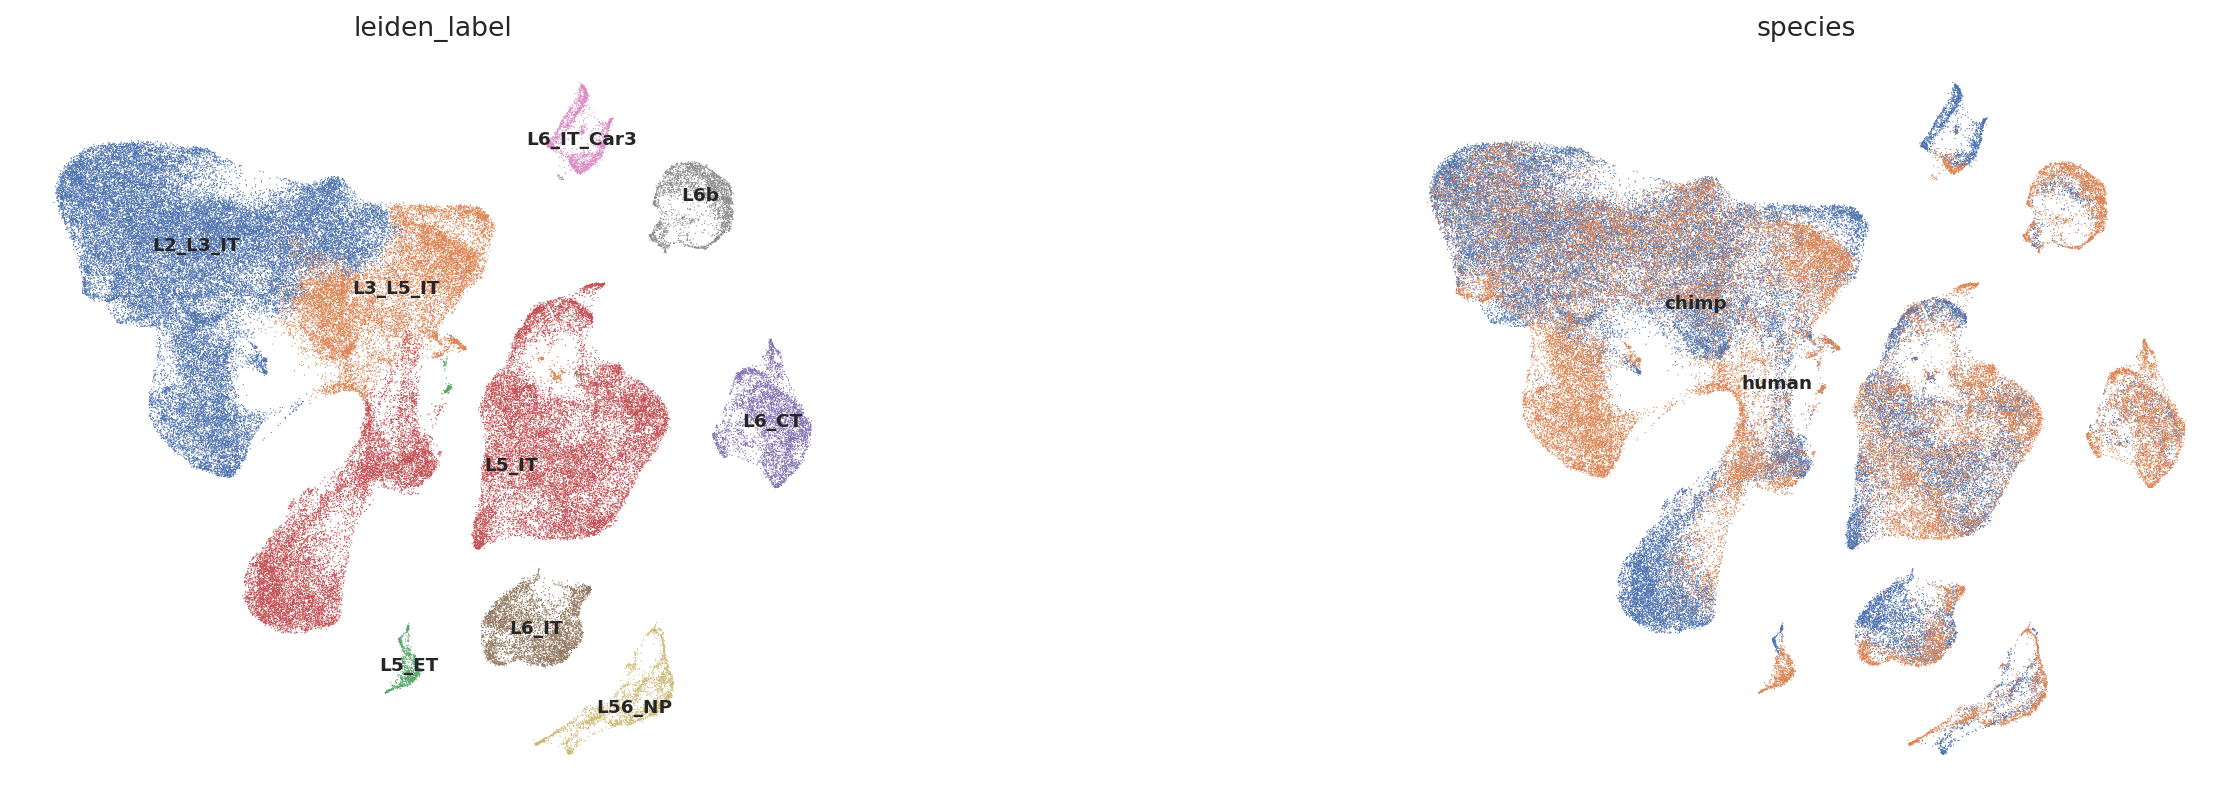

In [ ]:
sc.pl.umap(
    primate_adata,
    color=["leiden_label","species"],
    frameon=False,
    cmap="tab20",
    legend_loc = "on data",
    legend_fontsize = 'x-small',
    show=False,
    wspace=0.5
)

[<Axes: title={'center': 'leiden_label'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'species'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'RORB'}, xlabel='UMAP1', ylabel='UMAP2'>]

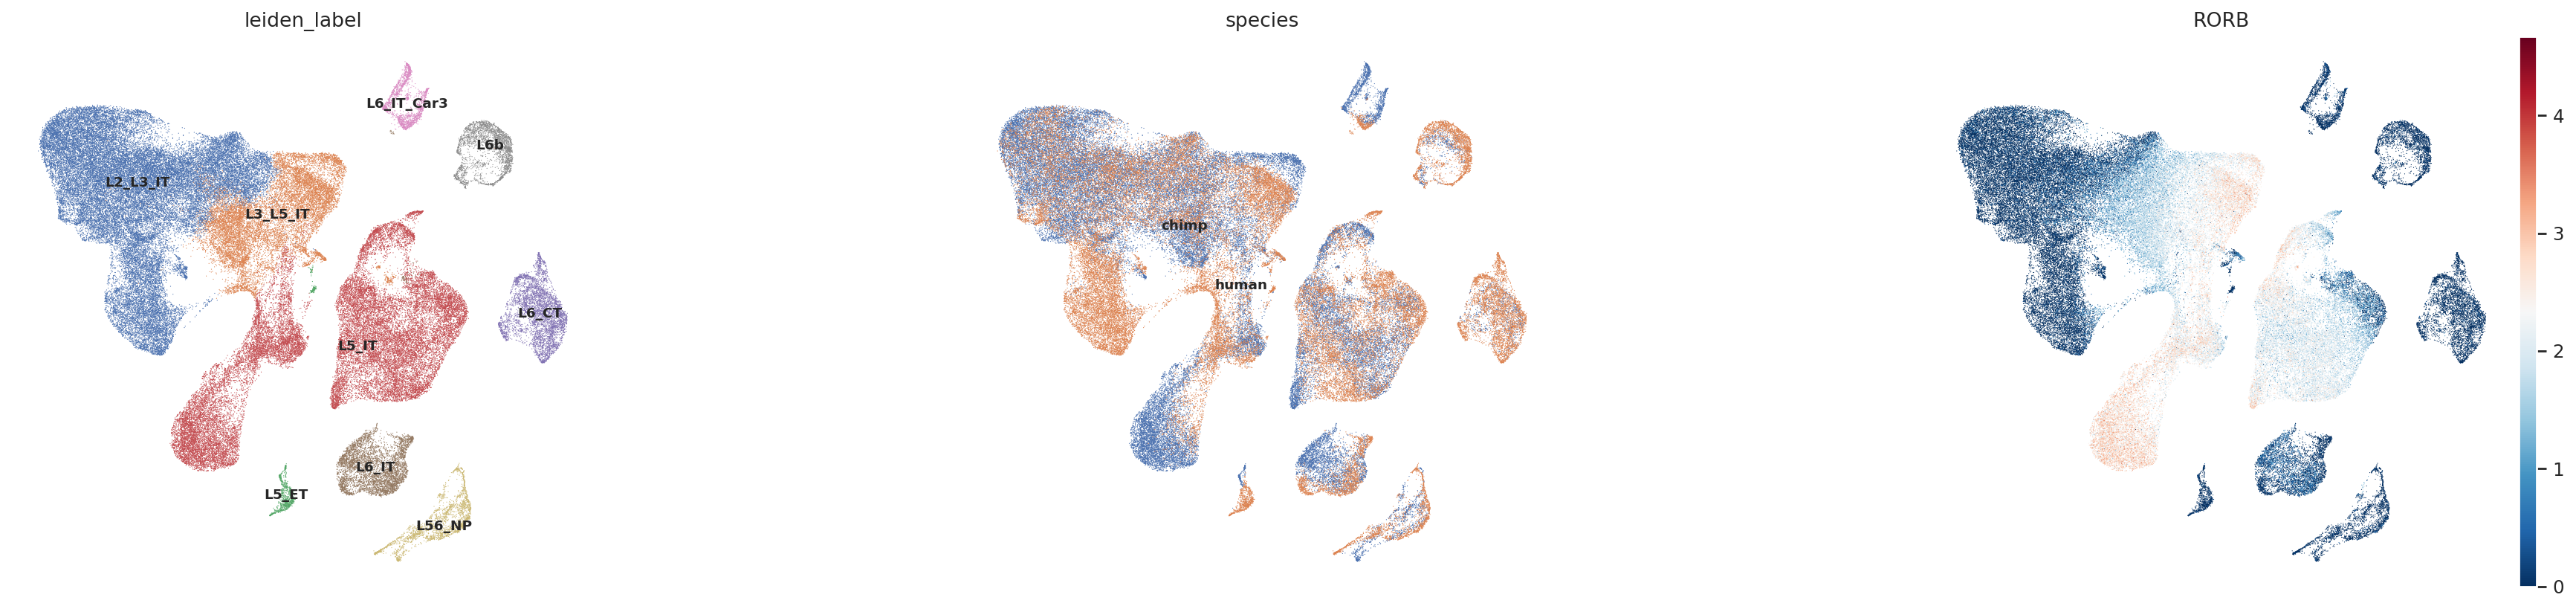

In [ ]:
sc.pl.umap(
    primate_adata,
    color=["leiden_label","species","RORB","PLCH1","CUX2","PLD5"],
    frameon=False,
    cmap="RdBu_r",
    #legend_loc = "on data",
    legend_fontsize = 'x-small',
    show=False,
    wspace=0.5
)